In [1]:
from pandas import read_csv
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [69]:
def supervisedReframer(df, steps_back=1, steps_forward=1):
    new_df = pd.DataFrame()
    new_df['Date'] = df['Date'].copy()
    new_df['Date'] = pd.to_datetime(new_df['Date'], origin='1899-12-30', unit='D')
    
    for col in df.columns:
        if col != "Date":
            for shift in range(steps_back, -1, -1):
                if shift != 0:
                    new_col_name = f"{col} (t-{shift})"
                else:
                    new_col_name = f"{col}"
                new_df[new_col_name] = df[col].shift(+shift).copy()

    new_df.drop(columns=['Adj Close'], inplace=True)
    new_df['Adj Close'] = df['Adj Close'].copy()
    for steps in range(1, steps_forward+1):
        new_col_name = f"Target (t+{steps})"
        new_df[new_col_name] = df['Adj Close'].shift(-steps).copy()

    new_df.dropna(inplace=True)

    return new_df


# def supervisedReframer(df, steps_back=1, steps_forward=1):
#     new_df = pd.DataFrame()
#     new_df['Date'] = df['Date'].copy()
    
#     # Shift columns backward
#     shifted_cols = {}
#     for col in df.columns:
#         if col != "Date":
#             shifted_cols[col] = [df[col].shift(-shift).copy() for shift in range(steps_back, -1, -1)]
#             new_col_names = [f"{col} (t-{shift})" if shift != 0 else f"{col}" for shift in range(steps_back, -1, -1)]
#             new_df = pd.concat([new_df] + shifted_cols[col], axis=1)
#             new_df.columns = new_df.columns[:1].tolist() + new_col_names + new_df.columns[1+len(new_col_names):].tolist()

#     # Shift 'Adj Close' column forward
#     for steps in range(1, steps_forward+1):
#         new_col_name = f"Adj Close (t+{steps})"
#         new_df[new_col_name] = df['Adj Close'].shift(-steps).copy()
    
#     return new_df


In [145]:
def TrainValTestSplit(dataframe, forward_steps=1):
    forward_steps+=1
    df=dataframe.copy()
    df['Year'] = df['Date'].dt.year.copy()

    # Determine the years for training, validation, and testing
    training_years = df['Year'].unique()[:-2]  # All years except the last two
    validation_year = df['Year'].unique()[-2]  # Second to last year
    testing_year = df['Year'].unique()[-1]  # Last year

    
    # Select columns for X and y
    X_columns = df.columns[1:-forward_steps]
    y_columns = df.columns[-forward_steps:-1]
    
    # Filter the data based on the years
    X_train = df[df['Year'].isin(training_years)][X_columns].values
    y_train = df[df['Year'].isin(training_years)][y_columns].values
    
    X_val = df[df['Year'] == validation_year][X_columns].values
    y_val = df[df['Year'] == validation_year][y_columns].values
    
    X_test = df[df['Year'] == testing_year][X_columns].values
    y_test = df[df['Year'] == testing_year][y_columns].values
    
    scaler = MinMaxScaler()
    
    # X_train = X_train.reshape(-1,1)
    # X_val = X_val.reshape(-1,1)
    # X_test = X_test.reshape(-1,1)
    
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    X_test = scaler.fit_transform(X_test)
    
    y_train = scaler.fit_transform(y_train)
    y_val = scaler.fit_transform(y_val)
    y_test = scaler.fit_transform(y_test)
    
    
    # X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    # X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # y_train = y_train.reshape(-1,1)
    # y_val = y_val.reshape(-1,1)
    # y_test = y_test.reshape(-1,1)
    

    return X_train,y_train,X_val,y_val,X_test,y_test

In [149]:
n_steps_back = 5 # Ako je 0, to znaci da koristis danas da predvidis sutra
n_steps_forward = 5

# load dataset
dataset = read_csv('CSV Files with Calculated Indicators/NYSE.csv', low_memory=False, header=0, index_col=None)

df = pd.DataFrame({
    'Date': dataset['Date'], 
    'Adj Close': dataset['Adj Close']})

moved_df = supervisedReframer(df, n_steps_back, n_steps_forward).copy()

X_train,y_train,X_val,y_val,X_test,y_test = TrainValTestSplit(moved_df,n_steps_forward)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

print(y_train[0])

(5065, 6)
(5065, 5)
(251, 6)
(251, 5)
(245, 6)
(245, 5)
[0.11850477 0.12602617 0.1273488  0.13234098 0.13758336]


Epoch 1/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0676 - val_loss: 0.0057
Epoch 2/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 3/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.8500e-04 - val_loss: 0.0057
Epoch 4/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.7556e-04 - val_loss: 0.0055
Epoch 5/5
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.3366e-04 - val_loss: 0.0054
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
LSTM coefficient of determination of the prediction:  0.8524138277271189


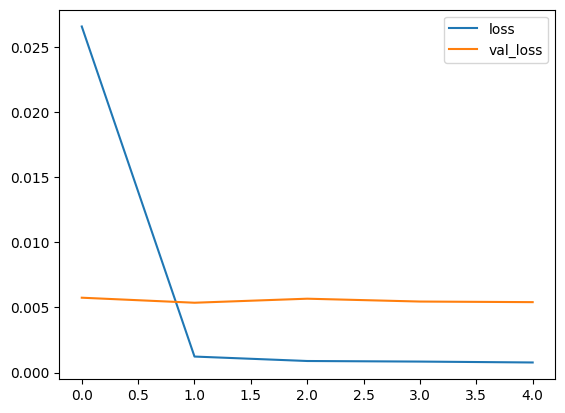

In [22]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse")
# model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs = 5,
    batch_size = 32,
    validation_data=(X_val, y_val),
    verbose=1
)

# estimate the R2 on the test set
print("LSTM coefficient of determination of the prediction: ", r2_score(y_test, model.predict(X_test)))

# fit model
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


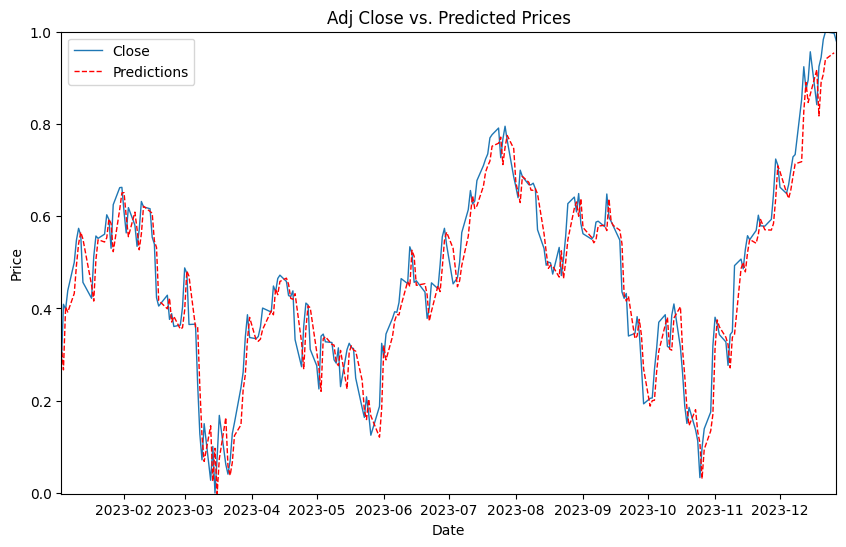

In [23]:
predictions = model.predict(X_test)
predictions = predictions.ravel().tolist()

graph_df = pd.DataFrame({
    'True': y_test, 
    'Predictions': predictions})

last_n_dates = df['Date'].tail(len(graph_df)).tolist()
last_n_dates
graph_df['Date'] = last_n_dates

graph_df['Predictions'] = graph_df['Predictions'].shift(-1)

#Plotting
x_min = graph_df['Date'].iloc[0]  # Replace with your desired minimum x-axis value
x_max = graph_df['Date'].iloc[-1]  # Replace with your desired maximum x-axis value
y_min = min(graph_df['True'].min(), graph_df['Predictions'].min())  # Replace with your desired minimum y-axis value
y_max = max(graph_df['True'].max(), graph_df['Predictions'].max())  # Replace with your desired maximum y-axis value


# Assuming your DataFrame is named df
# Replace 'Date', 'Close', and 'Predicted' with your actual column names
plt.figure(figsize=(10, 6))
plt.plot(graph_df['Date'], graph_df['True'], label='Close', linewidth=1)
plt.plot(graph_df['Date'], graph_df['Predictions'], label='Predictions', linestyle='dashed', color='red', linewidth=1)

# Customize the plot
plt.title('Adj Close vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Set x-axis and y-axis value ranges
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.grid(False)
plt.xticks(rotation=0)

# Show the plot
plt.show()
